In [1]:
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from halomod import HaloModel
from halomod import TracerHaloModel as HM
import os
import imageio.v2 as imageio
from IPython.display import Image, display

(1e-25, 0.0001)

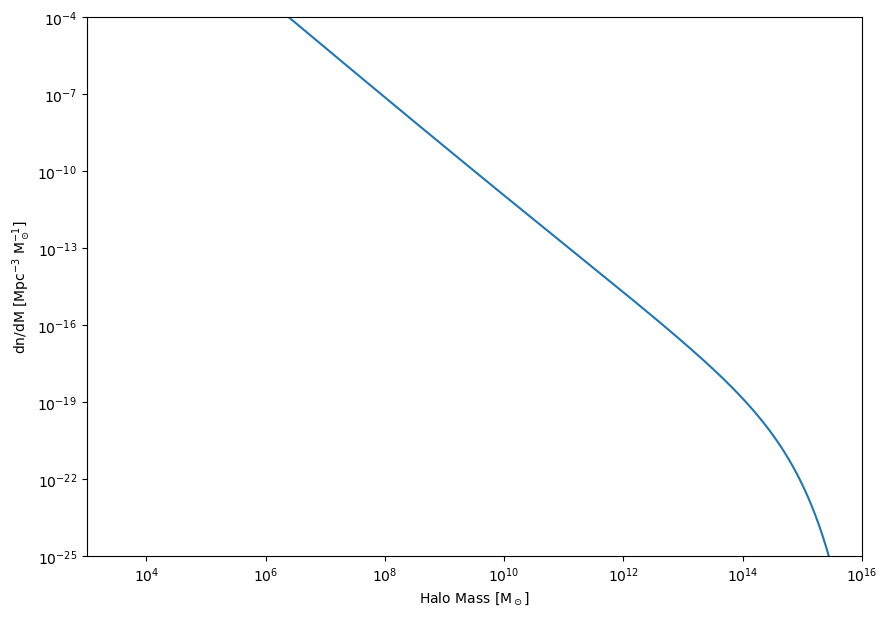

In [16]:
# Define CLASS parameters (Planck2018)
params = {
    'tau_reio':0.054,
    'omega_cdm':0.120,
    'omega_b':0.0224,
    'n_s':0.965,
    'A_s':np.exp(3.044)/10**10,
    'h':0.673, 
    "output": 'tCl,pCl,lCl,mPk,mTk',
    "lensing": 'yes', 
    "P_k_max_1/Mpc": 3.0,
    "T_cmb": 2.72548, 
    "z_pk": 0.0
}

# Run CLASS
cosmo = Class()
cosmo.set(params)
cosmo.compute()

# Get the transfer function
transfer_function_class = cosmo.get_transfer(output_format='camb')

# Define HaloModel with CLASS transfer function
hm = HaloModel(
    transfer_model='FromArray',
    transfer_params={'k': transfer_function_class['k (h/Mpc)'], 
                     'T': transfer_function_class['-T_tot/k2']}, 
    cosmo_params={"Ob0": params['omega_b'], 
                  "Om0": params['omega_b'] + params['omega_cdm'],  # total matter density
                  "H0": params['h'] * 100},  # Hubble constant in km/s/Mpc
    hmf_model='ST'
)

# Plot the halo mass function
plt.figure(figsize=(10, 7))
plt.loglog(hm.m, hm.dndm)
plt.xlabel('Halo Mass [M$_\odot$]')
plt.ylabel('dn/dM [Mpc$^{-3}$ M$_\odot^{-1}$]')
plt.xlim(1e3, 1e16)
plt.ylim(1e-25, 10e-5)

In [ ]:
def run_class(params):
    """
    Obtain the transfer function from CLASS using given cosmological parameters.
    
    Parameters:
    - params (dict): A dictionary of cosmological parameters for CLASS.
                     Example: {'omega_b': 0.022, 'omega_cdm': 0.12, ...}
    
    Returns:
    - dict: Transfer function data in the 'camb' format.
    
    Usage:
    >>> params = {'omega_b': 0.022, 'omega_cdm': 0.12, 'h': 0.67}
    >>> tf = run_class(params)
    """
    
    # Initialize CLASS
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()

    # Get the transfer function
    transfer_function_class = cosmo.get_transfer(output_format='camb')

    return transfer_function_class



In [ ]:

def generate_halo_model(transfer_function_class, params):
    """
    Generate a halo model using a given transfer function from CLASS and cosmological parameters.
    
    Parameters:
    - transfer_function_class (dict): Transfer function data obtained from CLASS.
                                     It should contain 'k (h/Mpc)' and '-T_tot/k2' keys among others.
    - params (dict): A dictionary of cosmological parameters. 
                     Example: {'omega_b': 0.022, 'omega_cdm': 0.12, ...}
    
    Returns:
    - HaloModel object: A `HaloModel` object constructed with the provided transfer function and parameters.
    
    Usage:
    >>> params = {'omega_b': 0.022, 'omega_cdm': 0.12, 'h': 0.67}
    >>> tf = run_class(params)
    >>> hm = generate_halo_model(tf, params)
    """
    
    # Check if 'omega_ncdm' is in params. If not, assume it's 0.
    omega_ncdm = params['omega_ncdm'] if 'omega_ncdm' in params else 0.0

    # Define HaloModel with CLASS transfer function
    hm = HaloModel(
        transfer_model='FromArray',
        transfer_params={'k': transfer_function_class['k (h/Mpc)'], 
                         'T': transfer_function_class['-T_tot/k2']}, 
        cosmo_params={"Ob0": params['omega_b'], "Om0": params['omega_b'] + params['omega_cdm'] + omega_ncdm, "H0": params['h'] * 100}, 
        hmf_model='ST'
    )
    
    return hm

In [2]:
# Define functions for future use
def plot_halo_mass_function(hm):
    # Plot the halo mass function
    plt.figure(figsize=(10, 7))
    plt.loglog(hm.m, hm.dndm)
    plt.xlabel('Halo Mass [M$_\odot$]')
    plt.ylabel('dn/dM [Mpc$^{-3}$ M$_\odot^{-1}$]')
    plt.xlim(1e3, 1e16)
    plt.ylim(1e-25, 10e5)
    plt.show()

In [18]:
def generate_gif(param_names, param_values1, param_values2, base_params):
    images = []
    filenames = []
    for value1, value2 in zip(param_values1, param_values2):
        params = base_params.copy()
        params[param_names[0]] = value1
        params[param_names[1]] = value2

        # Get the transfer function
        transfer_function_class = run_class(params)
        
        # Generate the HM model
        hm_custom = generate_halo_model(transfer_function_class, params)

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm_custom.m, hm_custom.dndm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e16)
        plt.ylim(1e-25, 10e-5)
        title = f'Halo Mass Function for {param_names[0]}={value1}, {param_names[1]}={value2}'
        plt.title(title)

        # Save the figure as a png file
        filename = f'{param_names[0]}_{value1}_{param_names[1]}_{value2}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = f'{param_names[0]}_{param_names[1]}_gif.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))


In [3]:
def generate_gif_one(param_name, param_values, base_params):
    images = []
    filenames = []

    for value in param_values:
        params = base_params.copy()
        params[param_name] = value

        # Get the transfer function
        transfer_function_class = run_class(params)
        
        # Generate the HM model
        hm_custom = generate_halo_model(transfer_function_class, params)

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm_custom.m, hm_custom.dndm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e16)
        plt.ylim(1e-25, 10e-5)
        title = f'Halo Mass Function for {param_name}={value}'
        plt.title(title)

        # Save the figure as a png file
        filename = f'{param_name}_{value}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = f'{param_name}_gif.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))


In [1]:
# Define CLASS parameters
params_2018 = {
    'tau_reio':0.0544,
    'omega_cdm':0.12,
    'omega_b':0.02237,
    'n_s':0.9649,
    'h':0.6736, 
    "output": 'tCl,pCl,lCl,mPk,mTk',
    "lensing": 'yes', 
    "P_k_max_1/Mpc": 3.0,
    "T_cmb": 2.72548, 
    "z_pk": 0.0, 
    "sigma8": 0.8111
}

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


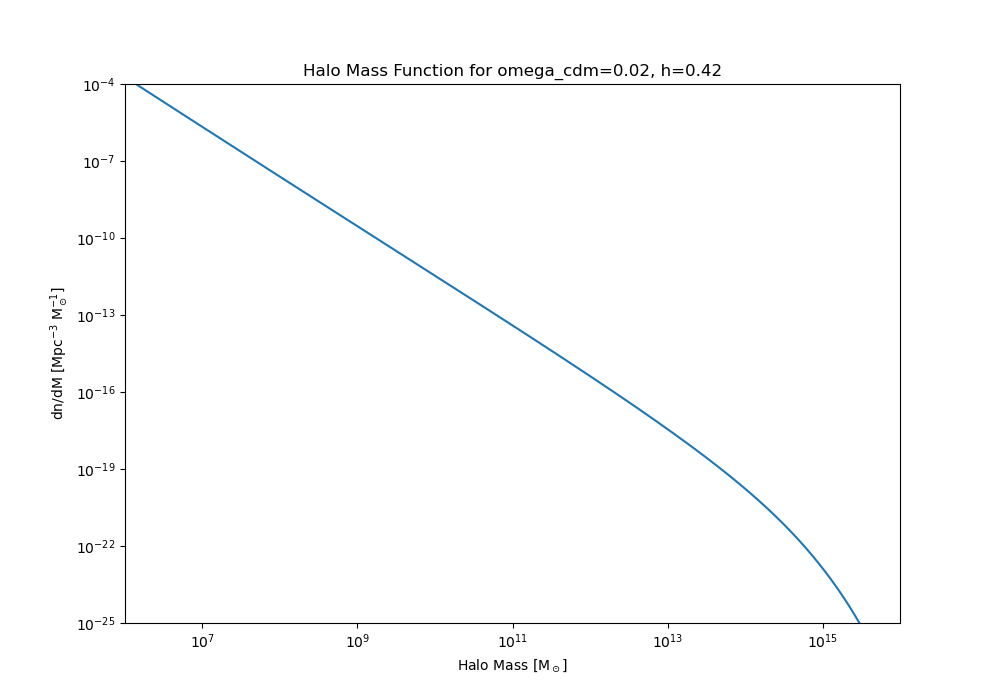

In [19]:
omega_d_values = [0.020, 0.030, 0.050, 0.080, 0.13, 0.20, 0.30, 0.50, 0.80]
h_values = [0.42, 0.47, 0.55, 0.65, 0.80, 0.96, 1.2, 1.5, 1.9]
generate_gif(['omega_cdm', 'h'], omega_d_values, h_values, params)

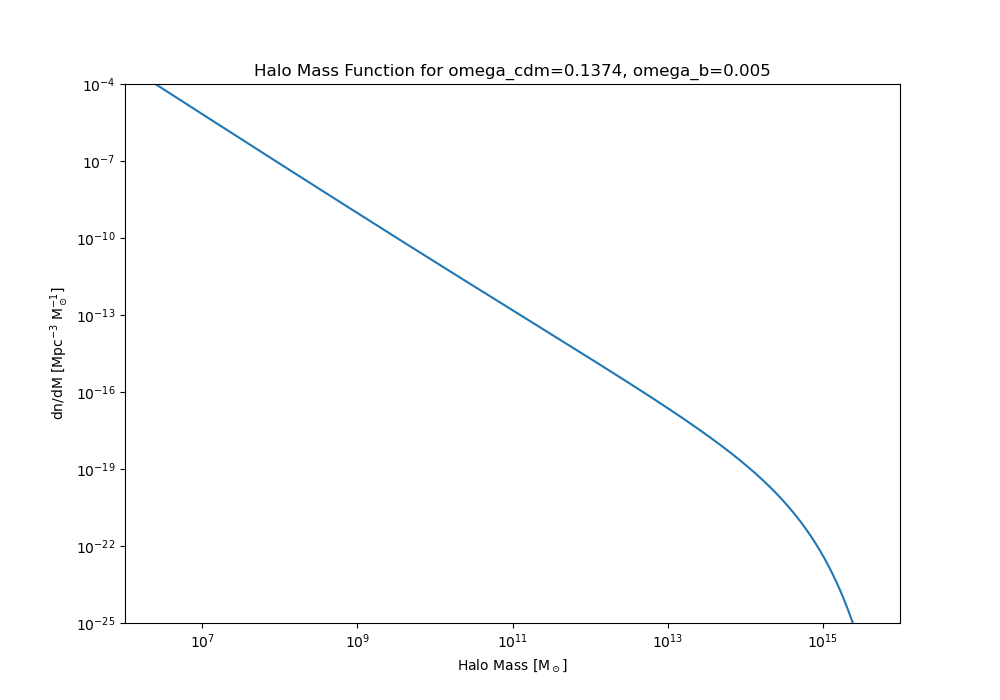

In [ ]:
omega_b_values = [0.005, 0.007, 0.013, 0.019, 0.025, 0.031, 0.038]
omega_cdm_values = [0.1424 - omega_b for omega_b in omega_b_values]
generate_gif(['omega_cdm', 'omega_b'], omega_cdm_values, omega_b_values, params)